In [51]:
import sys
sys.path.append("/home/gant/Documents/tpcanalysis/python_comp/src")
from openImage import openImage
import matplotlib.pyplot as plt
import numpy as np

from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line
from skimage.feature import canny
from skimage.draw import line
from skimage.color import rgb2gray
from skimage.color import label2rgb
from skimage.segmentation import slic
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries

from matplotlib import cm

In [54]:
test_image = openImage("/media/gant/Expansion/tpc_root_raw/DATA_ROOT/cleanimages/CoBo_2018-06-20T10-51-39.459_0000/25_w.png")
test_image.readImage()
test_image.trimImage()
test_image.m_data = np.where(test_image.m_data > 0.99, 0, test_image.m_data)

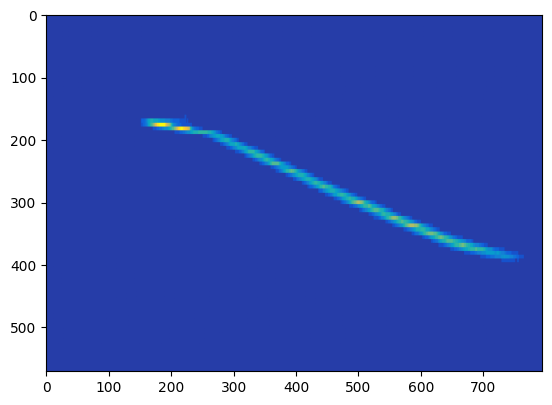

In [55]:
#test MatPlotLib
test_image.viewImage()

In [56]:
#black and white

test_image.m_data = rgb2gray(test_image.m_data)
test_image.m_data = np.where(test_image.m_data < 0.5, 0, test_image.m_data)


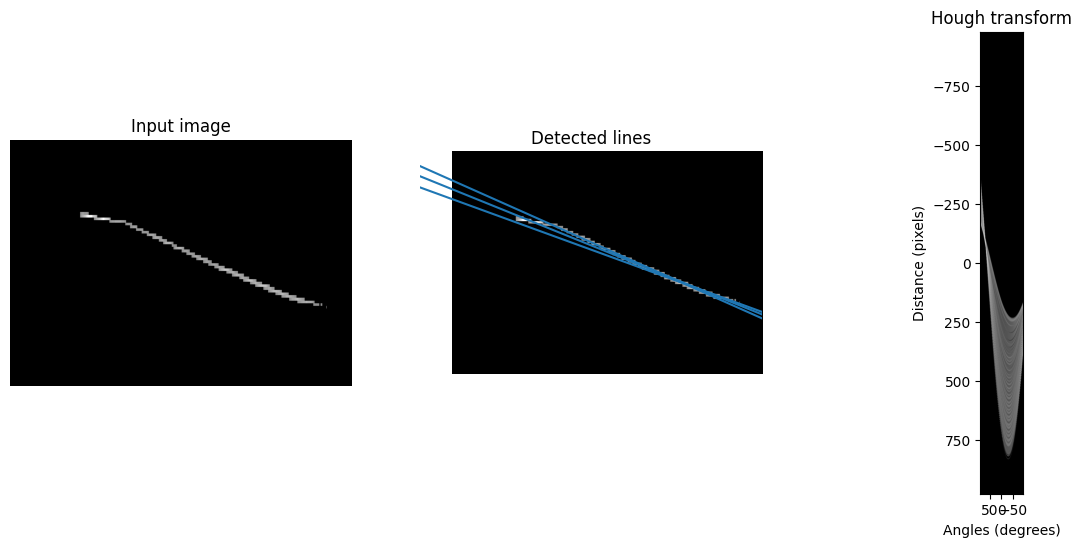

In [59]:
#hough transform

""" tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 180, endpoint=False)
h, theta, d = hough_line(test_image.m_data, theta=tested_angles) """
h, theta, d = hough_line(test_image.m_data)

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(test_image.m_data, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(test_image.m_data, cmap=cm.gray)
ax[1].set_ylim((test_image.m_data.shape[0], 0))
ax[1].set_axis_off()
ax[1].set_title('Detected lines')



ax[2].imshow(np.log(1 + h), extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),
           d[-1], d[0]], cmap=cm.gray, aspect=1/1.5)
ax[2].set_title('Hough transform')
ax[2].set_xlabel('Angles (degrees)')
ax[2].set_ylabel('Distance (pixels)')
ax[2].axis('image')



for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[1].axline((x0, y0), slope=np.tan(angle + np.pi/2))

""" origin = np.array((0, test_image.m_data.shape[0]))


for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[1].plot(origin, (y0, y1), '-r') """




plt.show()

Number of lines: 14
Slope is 0.4649350649350649

Slope is 0.22826086956521738



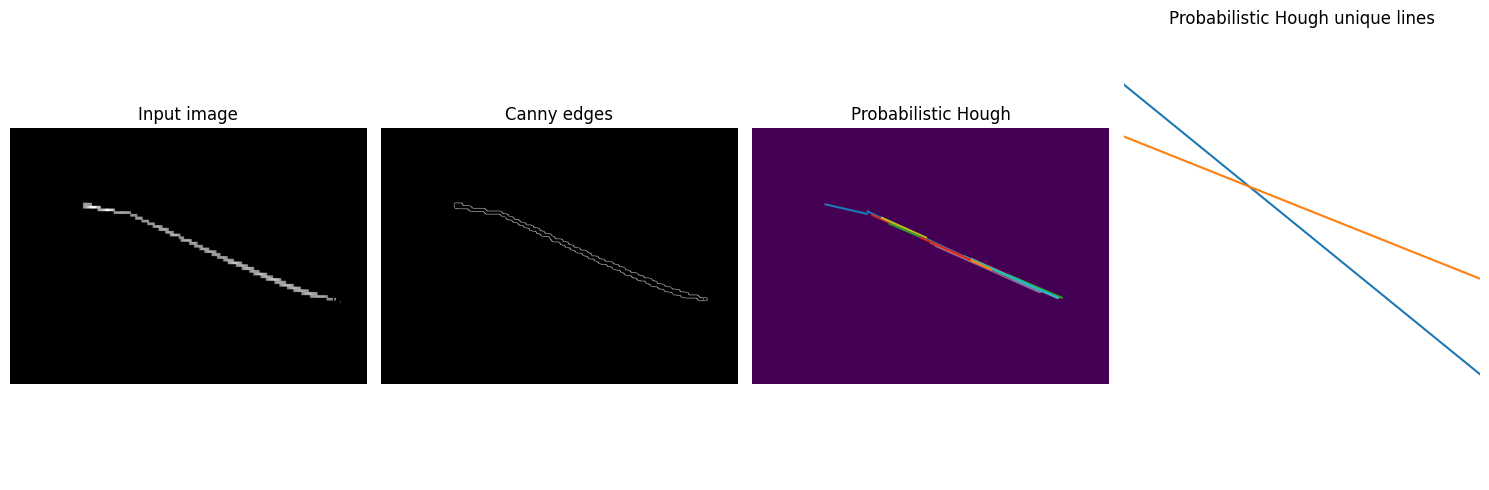

In [98]:
#canny edges and probabilistic hough transform

edges = canny(test_image.m_data, sigma = 2.5)
lines = probabilistic_hough_line(test_image.m_data, threshold=10, line_length=90,
                                 line_gap=3, seed = 0)

# Generating figure 2
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(test_image.m_data, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0)


def get_slope_intercept(p0, p1):
    if p1[0] - p0[0] != 0:
        slope = (p1[1] - p0[1]) / (p1[0] - p0[0])
    else:
        slope = float('inf')

    intercept = p0[1] - slope * p0[0]

    return slope, intercept




line_s_i_format=[]

for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))

    line_s_i_format.append(get_slope_intercept(p0, p1))

ax[2].set_xlim((0, test_image.m_data.shape[1]))
ax[2].set_ylim((test_image.m_data.shape[0], 0))
ax[2].set_title('Probabilistic Hough')


print(f"Number of lines: {len(line_s_i_format)}")

""" for slope, intercept in line_s_i_format:
    print(f"Slope is {slope}\nIntercept is {intercept}\n\n") """

unique_lines=[]
slopes_th=0.05

for slope, intercept in line_s_i_format:
    if unique_lines == False:
        unique_lines.append((slope, intercept))
        print(f"Slope is {slope}\n")
    else:
        if all(abs(slope - unique_slope) > slopes_th for unique_slope, _ in unique_lines):
            unique_lines.append((slope, intercept))
            print(f"Slope is {slope}\n")



ax[3].imshow(edges * 0)
ax[3].set_xlim((0, test_image.m_data.shape[1]))
ax[3].set_ylim((test_image.m_data.shape[0], 0))
ax[3].set_title('Probabilistic Hough unique lines')

x = np.linspace(0, test_image.m_data.shape[1], 100)

for slope, intercept in unique_lines:
    y = slope * x + intercept
    ax[3].plot(x, y)


for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

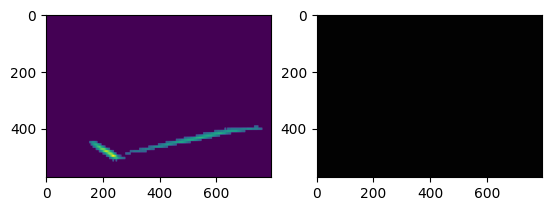

In [65]:
#Simple linear iterative clustering

ul_image = openImage("/media/gant/Expansion/tpc_root_raw/DATA_ROOT/cleanimages/CoBo_2018-06-20T10-51-39.459_0000/25_u.png")
ul_image.readImage()



ul_image.trimImage()
ul_image.m_data = rgb2gray(ul_image.m_data)
ul_image.m_data = np.where(ul_image.m_data < 0.3, 0, ul_image.m_data)




ul_segments = slic(ul_image.m_data,
                          n_segments=2,
                          compactness=10)
plt.subplot(1,2,1)
 
# Plotting the original image
plt.imshow(ul_image.m_data)
plt.subplot(1,2,2)
 
# Converts a label image into
# an RGB color image for visualizing
# the labeled regions.
plt.imshow(label2rgb(ul_segments,
                     ul_image.m_data,
                     kind = 'avg'))

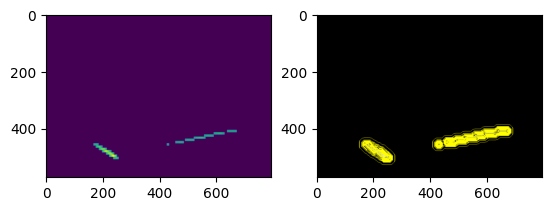

In [66]:
#elzenszwalb


uf_image = openImage("/media/gant/Expansion/tpc_root_raw/DATA_ROOT/cleanimages/CoBo_2018-06-20T10-51-39.459_0000/25_u.png")
uf_image.readImage()


uf_image.trimImage()
uf_image.m_data = rgb2gray(uf_image.m_data)
uf_image.m_data = np.where(uf_image.m_data < 0.5, 0, uf_image.m_data)






uf_segments = felzenszwalb(uf_image.m_data,
                                  scale = 5,
                                  sigma=5,
                                  min_size=20)
 
# Plotting the original image
plt.subplot(1,2,1)
plt.imshow(uf_image.m_data)
 
# Marking the boundaries of
# Felzenszwalb's segmentations
plt.subplot(1,2,2)
plt.imshow(mark_boundaries(uf_image.m_data,
                           uf_segments))


In [ ]:
#cu xyz
""" xyz_image = openImage("./datafiles/test_xyz.png")
xyz_image.readImage()


#black and white

xyz_image.m_data = rgb2gray(xyz_image.m_data)
xyz_image.m_data[:, 0] = 0.99
xyz_image.m_data = 1 - xyz_image.m_data
xyz_image.m_data = np.where(xyz_image.m_data < 0.5, 0, xyz_image.m_data) """

In [ ]:
#hough transform cu xyz
""" 
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
#h, theta, d = hough_line(test_image.m_data, theta=tested_angles)
h, theta, d = hough_line(xyz_image.m_data)

fig_xyz, axes_xyz = plt.subplots(1, 2, figsize=(15, 6))
ax_xyz = axes_xyz.ravel()

ax_xyz[0].imshow(xyz_image.m_data, cmap=cm.gray)
ax_xyz[0].set_title('Input image')
ax_xyz[0].set_axis_off()

ax_xyz[1].imshow(xyz_image.m_data, cmap=cm.gray)
ax_xyz[1].set_ylim((xyz_image.m_data.shape[0], 0))
ax_xyz[1].set_axis_off()
ax_xyz[1].set_title('Detected lines')

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax_xyz[1].axline((x0, y0), slope=np.tan(angle + np.pi/2))



plt.show() """